In [1]:
import math
import numpy as np
from packages.fmm import *
import packages.general as general

# Timing

In [2]:
# storage lists

particle_numbers = np.logspace(1, 7, 25, dtype=int)
pairwise_times = []
fmm_times = []

precision = 5

In [3]:
# standard pairwise

for num in particle_numbers:
    particles = [general.Particle() for _ in range(num)]
    print(f'Num: {num}')
    time = %timeit -o general.direct_particle_potentials(particles)
    pairwise_times.append(time)
    if time.average > 20:
        break

Num: 10
47.7 µs ± 2.48 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Num: 17
135 µs ± 2.27 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Num: 31
448 µs ± 498 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Num: 56
1.49 ms ± 27.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Num: 100
4.72 ms ± 9.05 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Num: 177
15.7 ms ± 262 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Num: 316
49.6 ms ± 283 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Num: 562
157 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Num: 1000
500 ms ± 2.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Num: 1778
1.59 s ± 18.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Num: 3162
5.02 s ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Num: 5623
15.9 s ± 22.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Num: 10000
50.3 s ± 69.7 ms per loop (mean

In [2]:
# fmm

def do_fmm(precision, max_level, particles, expansion_arrays):
    for particle in particles:
        particle.potential = 0.0
    
    for level in range(len(expansion_arrays)):
        expansion_arrays[level][:,:,1:] = 0
    finest_particles = insert_particles(precision, max_level, particles, expansion_arrays[max_level])
    upward_pass(precision, expansion_arrays)
    downward_pass(precision, expansion_arrays)
    evaluate_particle_potentials(precision, max_level, finest_particles, expansion_arrays[max_level])


for num in particle_numbers:
    particles = [Particle() for _ in range(num)]
    max_level = int(0.5 * math.log2(num))
    expansion_arrays = create_expansion_arrays(precision, max_level)

    print(f'Num: {num}, Max_level: {max_level}')
    time = %timeit -o do_fmm(precision, max_level, particles, expansion_arrays)
    fmm_times.append(time)
    if time.average > 100:
        break

NameError: name 'particle_numbers' is not defined

In [5]:
pairwise_average = [time.average for time in pairwise_times]
pairwise_stdev = [time.stdev for time in pairwise_times]
fmm_average = [time.average for time in fmm_times]
fmm_stdev = [time.stdev for time in fmm_times]

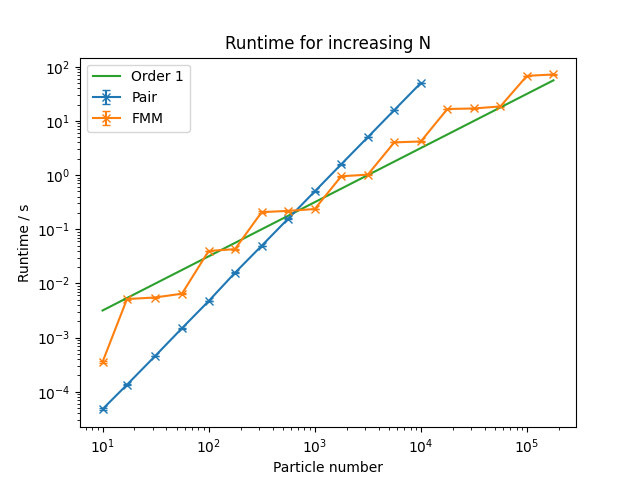

In [15]:
import matplotlib.pyplot as plt
%matplotlib widget

fig, ax = plt.subplots()

ax.errorbar(particle_numbers[:len(pairwise_average)], pairwise_average, yerr=pairwise_stdev, fmt='x-', capsize=3, label='Pair')
ax.errorbar(particle_numbers[:len(fmm_average)], fmm_average, yerr=fmm_stdev, fmt='x-', capsize=3, label='FMM')

ax.plot(particle_numbers[:len(fmm_average)], (particle_numbers[:len(fmm_average)]**1) * 10**-3.5, label='Order 1')
# ax.set_aspect('equal')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Particle number")
ax.set_ylabel("Runtime / s")
ax.set_title("Runtime for increasing N")
ax.legend()

plt.show()

# Errors

In [29]:
import math
import numpy as np
import matplotlib.pyplot as plt

import fmm

%matplotlib widget

In [2]:

import importlib
importlib.reload(fmm)

<module 'fmm' from '/Users/liambrown/repositories/computing-project-lb880/fmm/__init__.py'>

In [3]:
precision = 4
num_particles = 1000

particles = [general.Particle() for _ in range(num_particles)]

max_level = int(0.5 * math.log2(num_particles))

expansion_arrays = fmm.create_expansion_arrays(precision, max_level)

In [13]:
fmm.do_fmm(precision, particles, expansion_arrays, zero_potentials=True)
general.direct_particle_potentials(particles, zero_potentials=True)

fmm_pot = np.array([particle.potential for particle in particles])
dir_pot = np.array([particle.direct_potential for particle in particles])

In [14]:
difference = fmm_pot - dir_pot
fractional_error = difference / dir_pot
percent_error = 100*fractional_error

In [25]:
precisions = [4,6,10,20]

num_particles = 10000
particles = [general.Particle() for _ in range(num_particles)]
max_level = int(0.5 * math.log2(num_particles))

fractionals = []

for precision in precisions:
    expansion_arrays = fmm.create_expansion_arrays(precision, max_level)

    fmm.do_fmm(precision, particles, expansion_arrays, zero_potentials=True)
    fmm.direct_particle_potentials(particles, zero_potentials=True)

    fmm_pot = np.array([particle.potential for particle in particles])
    dir_pot = np.array([particle.direct_potential for particle in particles])

    difference = fmm_pot - dir_pot
    fractionals.append(difference / dir_pot)

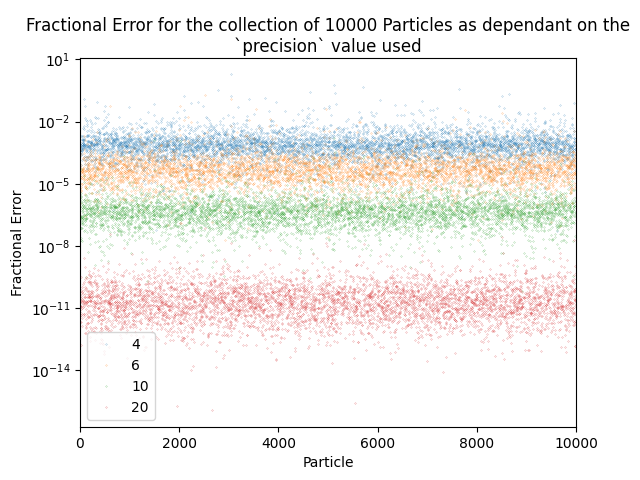

In [53]:
fig, ax = plt.subplots()
for i, precision in enumerate(precisions):
    ax.plot(fractionals[i], '.', markersize=0.3, label=str(precision))
ax.set_yscale('log')
ax.set_xmargin(0)
ax.set_xticks(np.linspace(0,num_particles, 6))
ax.set_xlabel('Particle')
ax.set_ylabel('Fractional Error')
ax.set_title('Fractional Error for the collection of 10000 Particles as dependant on the `precision` value used', wrap=True)
ax.legend()

plt.show()